### The Purpose of this notebook is to setup the dependencies and data to show an example of how to train a simple cnn model.

### Later on we can modulize the phases to allow for faster and more comprehensive model testing of multiple types of models including custom models.

# 1. Setup

In [108]:
from pathlib import Path 
import polars as pl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

DATA_PARQUET: Path = Path("..") / "data" / "parquet"


# 2. Load parquet data 

In [109]:
# Load data
df_in = pl.read_parquet(DATA_PARQUET / "train_input.parquet")
df_out = pl.read_parquet(DATA_PARQUET / "train_output.parquet")

# Confirm data loaded correctly
print("Inputs:", df_in.shape, "Outputs:", df_out.shape)
df_in.head()

Inputs: (4880579, 24) Outputs: (562936, 7)


game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,week
i64,i64,bool,i64,i32,str,i32,str,str,i32,date,str,str,str,f64,f64,f64,f64,f64,f64,i32,f64,f64,i32
2023090700,101,false,54527,1,"""right""",42,"""Bryan Cook""","""6-1""",210,1999-09-07,"""FS""","""Defense""","""Defensive Coverage""",52.33,36.94,0.09,0.39,322.4,238.24,21,63.259998,-0.22,1
2023090700,101,false,54527,2,"""right""",42,"""Bryan Cook""","""6-1""",210,1999-09-07,"""FS""","""Defense""","""Defensive Coverage""",52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22,1
2023090700,101,false,54527,3,"""right""",42,"""Bryan Cook""","""6-1""",210,1999-09-07,"""FS""","""Defense""","""Defensive Coverage""",52.33,36.93,0.12,0.73,147.55,240.6,21,63.259998,-0.22,1
2023090700,101,false,54527,4,"""right""",42,"""Bryan Cook""","""6-1""",210,1999-09-07,"""FS""","""Defense""","""Defensive Coverage""",52.35,36.92,0.23,0.81,131.4,244.25,21,63.259998,-0.22,1
2023090700,101,false,54527,5,"""right""",42,"""Bryan Cook""","""6-1""",210,1999-09-07,"""FS""","""Defense""","""Defensive Coverage""",52.37,36.9,0.35,0.82,123.26,244.25,21,63.259998,-0.22,1


# 3. Join I/O to build sample sequences

In [110]:
# Join input and output data on identifiers
df = df_in.join(
    df_out.select(["game_id", "play_id", "nfl_id", "frame_id", "x", "y"]),
    on=["game_id", "play_id", "nfl_id", "frame_id"],
    how="inner",
    suffix="_label"
)

# Normalize label positions, remember generally
# x is between 0 and 120, y is between 0 and 53.3
df = df.with_columns([
    (pl.col("x_label") / 120.0).alias("x_norm"),
    (pl.col("y_label") / 53.3).alias("y_norm")
])

print(df.head())

# Example sequence grouping by game_id, play_id
sample_group = df.filter(pl.col("player_to_predict") == True).group_by(["game_id", "play_id"]).first()
print("Unique plays:", sample_group.height)

shape: (5, 28)
┌────────────┬─────────┬───────────────────┬────────┬───┬─────────┬─────────┬──────────┬──────────┐
│ game_id    ┆ play_id ┆ player_to_predict ┆ nfl_id ┆ … ┆ x_label ┆ y_label ┆ x_norm   ┆ y_norm   │
│ ---        ┆ ---     ┆ ---               ┆ ---    ┆   ┆ ---     ┆ ---     ┆ ---      ┆ ---      │
│ i64        ┆ i64     ┆ bool              ┆ i64    ┆   ┆ f64     ┆ f64     ┆ f64      ┆ f64      │
╞════════════╪═════════╪═══════════════════╪════════╪═══╪═════════╪═════════╪══════════╪══════════╡
│ 2023090700 ┆ 101     ┆ true              ┆ 46137  ┆ … ┆ 56.22   ┆ 17.28   ┆ 0.4685   ┆ 0.324203 │
│ 2023090700 ┆ 101     ┆ true              ┆ 46137  ┆ … ┆ 56.63   ┆ 16.88   ┆ 0.471917 ┆ 0.316698 │
│ 2023090700 ┆ 101     ┆ true              ┆ 46137  ┆ … ┆ 57.06   ┆ 16.46   ┆ 0.4755   ┆ 0.308818 │
│ 2023090700 ┆ 101     ┆ true              ┆ 46137  ┆ … ┆ 57.48   ┆ 16.02   ┆ 0.479    ┆ 0.300563 │
│ 2023090700 ┆ 101     ┆ true              ┆ 46137  ┆ … ┆ 57.91   ┆ 15.56   ┆ 0.48258

# 4. Prepare sequences and tensors

In [ ]:
# Define a fixed sequence length
SEQ_LEN: int = 100
sequences, targets = [], []

# Iterate over each player in each play to create sequences
for _, group in df.filter(pl.col("player_to_predict") == True).group_by(["game_id", "play_id", "nfl_id"]):
    group = group.sort("frame_id")
    features = group.select(["s", "a", "dir", "o"]).to_numpy()
    labels = group.select(["x_norm", "y_norm"]).to_numpy()
    
    # Pad if shorter than SEQ_LEN
    if len(features) < SEQ_LEN:
        pad = SEQ_LEN - len(features)
        features = np.pad(features, ((0, pad), (0, 0)))
        labels = np.pad(labels, ((0, pad), (0, 0)))

    # Truncate if longer than SEQ_LEN
    else:
        features = features[:SEQ_LEN]
        labels = labels[:SEQ_LEN]
    
    sequences.append(features)
    targets.append(labels)

    if len(sequences) >= 500:  # Limit for simple testings purposes
        break

# Convert to np arrays and confirm shapes
X = np.stack(sequences)
y = np.stack(targets)
print("Shape:", X.shape, y.shape)


Shape: (500, 5000, 4) (500, 5000, 2)


# 5. Create test CNN
https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv1d.html

In [112]:
class SimpleCNN(nn.Module):
    # A simple 1D CNN for sequence regression
    def __init__(self, input_dim=4, seq_len=50):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Linear(64, 2)

    # Fowards data through the model
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        return self.fc(x)

# 6. Train simple CNN model

In [ ]:
# Prepare data for training
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)


# Load data into DataLoader to create batches
dataset = TensorDataset(X_train, y_train)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, optimizer, and loss function
model = SimpleCNN(input_dim=4, seq_len=SEQ_LEN)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Train the simple CNN model with epoch count of passses
# Meaning pass through the entire dataset epochs times
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    # Iterate over batches
    for xb, yb in loader:
        optimizer.zero_grad() # Zero the gradients
        pred = model(xb) # Forward pass
        loss = criterion(pred, yb) # Compute loss
        loss.backward() # Back propagation
        optimizer.step() # Update weights
        total_loss += loss.item() # Accumulate loss

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(loader):.5f}")

Epoch 1/7 - Loss: 0.04019
Epoch 2/7 - Loss: 0.00166
Epoch 3/7 - Loss: 0.00056
Epoch 4/7 - Loss: 0.00032
Epoch 5/7 - Loss: 0.00026
Epoch 6/7 - Loss: 0.00023
Epoch 7/7 - Loss: 0.00022


# 7. Visualize predicition results

Average 2D RMSE across dataset: 0.907 yards


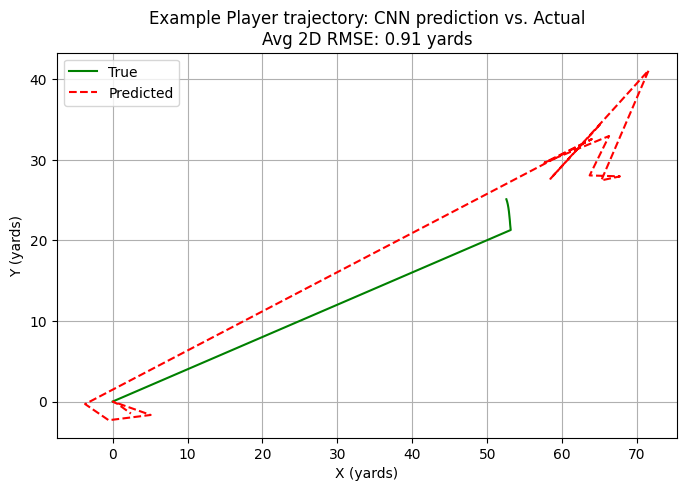

In [114]:
# Use the trained model to visualize predictions and compute average RMSE (in yards)
model.eval()
with torch.no_grad():
    preds = model(X_train).numpy()

# Unnormalize coordinates back to yards to compute RMSE
y_true_yards = y.copy()
y_true_yards[..., 0] *= 120.0   # X-axis (0–120 yards)
y_true_yards[..., 1] *= 53.3    # Y-axis (0–53.3 yards)

preds_yards = preds.copy()
preds_yards[..., 0] *= 120.0
preds_yards[..., 1] *= 53.3

# Compute RMSE using Kaggle provided formula
rmse = np.sqrt(np.mean((y_true_yards - preds_yards) ** 2) / 2.0)
print(f"Average 2D RMSE across dataset: {rmse:.3f} yards")

# Visualize one example
example_idx = 0
true_traj = y_true_yards[example_idx]
pred_traj = preds_yards[example_idx]

# Plot true vs predicted trajectory
plt.figure(figsize=(8, 5))
plt.plot(true_traj[:, 0], true_traj[:, 1], label="True", color="green")
plt.plot(pred_traj[:, 0], pred_traj[:, 1], label="Predicted", color="red", linestyle="--")
plt.xlabel("X (yards)")
plt.ylabel("Y (yards)")
plt.legend()
plt.title(f"Example Player trajectory: CNN prediction vs. Actual\nAvg 2D RMSE: {rmse:.2f} yards")
plt.grid(True)
plt.show()
